In [608]:
import pandas as pd
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
pd.options.mode.chained_assignment = None  # default='warn'

from preprocessing import *
from feature_engineering import *

df_merged = None
dir = "startcode/"
for file in os.listdir("startcode/"):
    df = read_xml(dir+file)
    df = keep_shots(df)
    df = goal_or_not(df)
    if df.empty:
        continue
    try:
        df = standard_pos(df)
    except:
        print(df.head())
    df = convert_time(df)
    df = df.iloc[1:]
    df["side"] = pd.to_numeric(df["side"].apply(lambda x: 1 if x=="home" else 0))
    
    if df_merged is None:
        df_merged = df
    else:
        df_merged = pd.concat([df_merged, df])
    

    type          stime  side  mtime       info matchscore  goals_1  goals_2  \
11    30  1651543020918  home  00:22  Goal [T1]        1:0        1        0   

    goals  ended_in_goal  
11      1            NaN  


In [1]:
import pandas as pd
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
pd.options.mode.chained_assignment = None  # default='warn'

from preprocessing import *

from pipeline import *
df_merged  = transform_events()

In [2]:
df = df_merged

In [4]:
df.columns

Index(['index', 'type', 'stime', 'side', 'mtime', 'info', 'matchscore',
       'extrainfo', 'posx', 'posy', 'home_team', 'away_team', 'goal',
       'shot_type', 'minutes', 'quarter', 'distance', 'angle', 'header',
       'penalty', 'shot'],
      dtype='object')

In [7]:
df = df[['posx', 'posy', 'goal', 'side', 'minutes', 'quarter', 'distance', 'angle', 'header', 'penalty', 'shot']]
df = df.dropna()

In [22]:
df['side'] = df['side'].apply(lambda x: 1 if x=='away' else 0)
train, test = train_test_split(df, test_size=0.2, stratify=df['goal'], random_state=42)

In [23]:
train.dtypes

posx        float64
posy        float64
goal        float64
side          int64
minutes       int32
quarter       int64
distance    float64
angle       float64
header        uint8
penalty       uint8
shot          uint8
dtype: object

In [24]:
model = xgb.XGBClassifier()
model.fit(train.drop('goal', axis=1, inplace=False), train['goal'])
model.save_model("test.json")

In [26]:
y_pred = model.predict_proba(test.drop('goal', axis=1, inplace=False))
y_pred_train = model.predict_proba(train.drop('goal', axis=1, inplace=False))
y_true = test['goal']

#print(f1_score(y_true, y_pred, average='weighted'))
test['xG'] = y_pred[:, 1]
train['xG'] = y_pred_train[:, 1]

print(accuracy_score(y_true, y_pred[:, 1] > 0.5))
print(mean_absolute_error(y_true, y_pred[:, 1]))


0.8606060606060606
0.18467318809410732


In [29]:
test[test['goal']==0].shape[0]/test.shape[0]

0.8414141414141414

In [30]:
test_back = test.copy()

In [554]:
test = test_back.copy()
#we are going to create a contour plot to see how the heaviside function classifies onto a pitch
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from mplsoccer import Pitch, VerticalPitch, Sbopen
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

def real_plot(test):

    pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency
    fig, ax = pitch.draw(figsize=(8, 6))

    test['posx'] = (100-test['posx'])*120/100
    test['posy'] = test['posy']*80/100

    test_goal = test[test['ended_in_goal']==1]
    test_non_goal = test[test['ended_in_goal']==0]

    goals = plt.scatter(data = test_goal, x='posy', y='posx',alpha=.7)
    misses = plt.scatter(data = test_non_goal, x='posy', y='posx',alpha=.7,marker='x')
    plt.legend((goals,misses),('Goal','Miss'))

    plt.show()

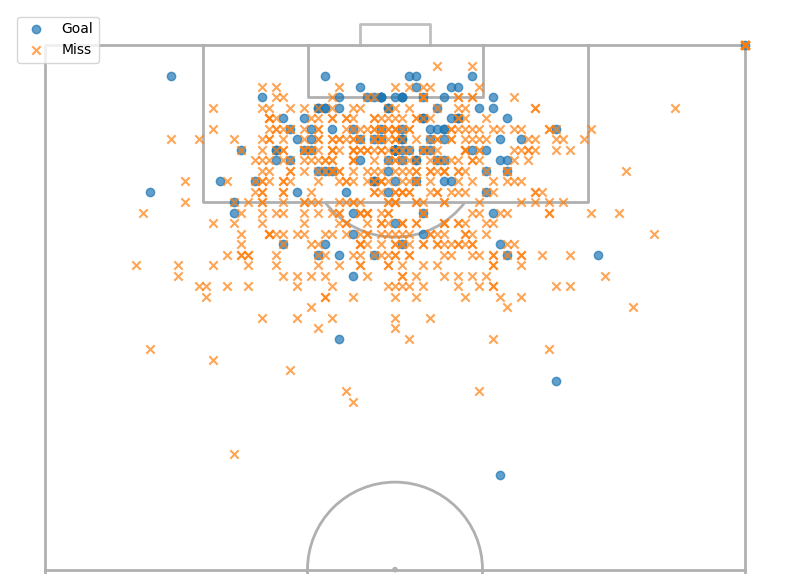

In [555]:
real_plot(test)

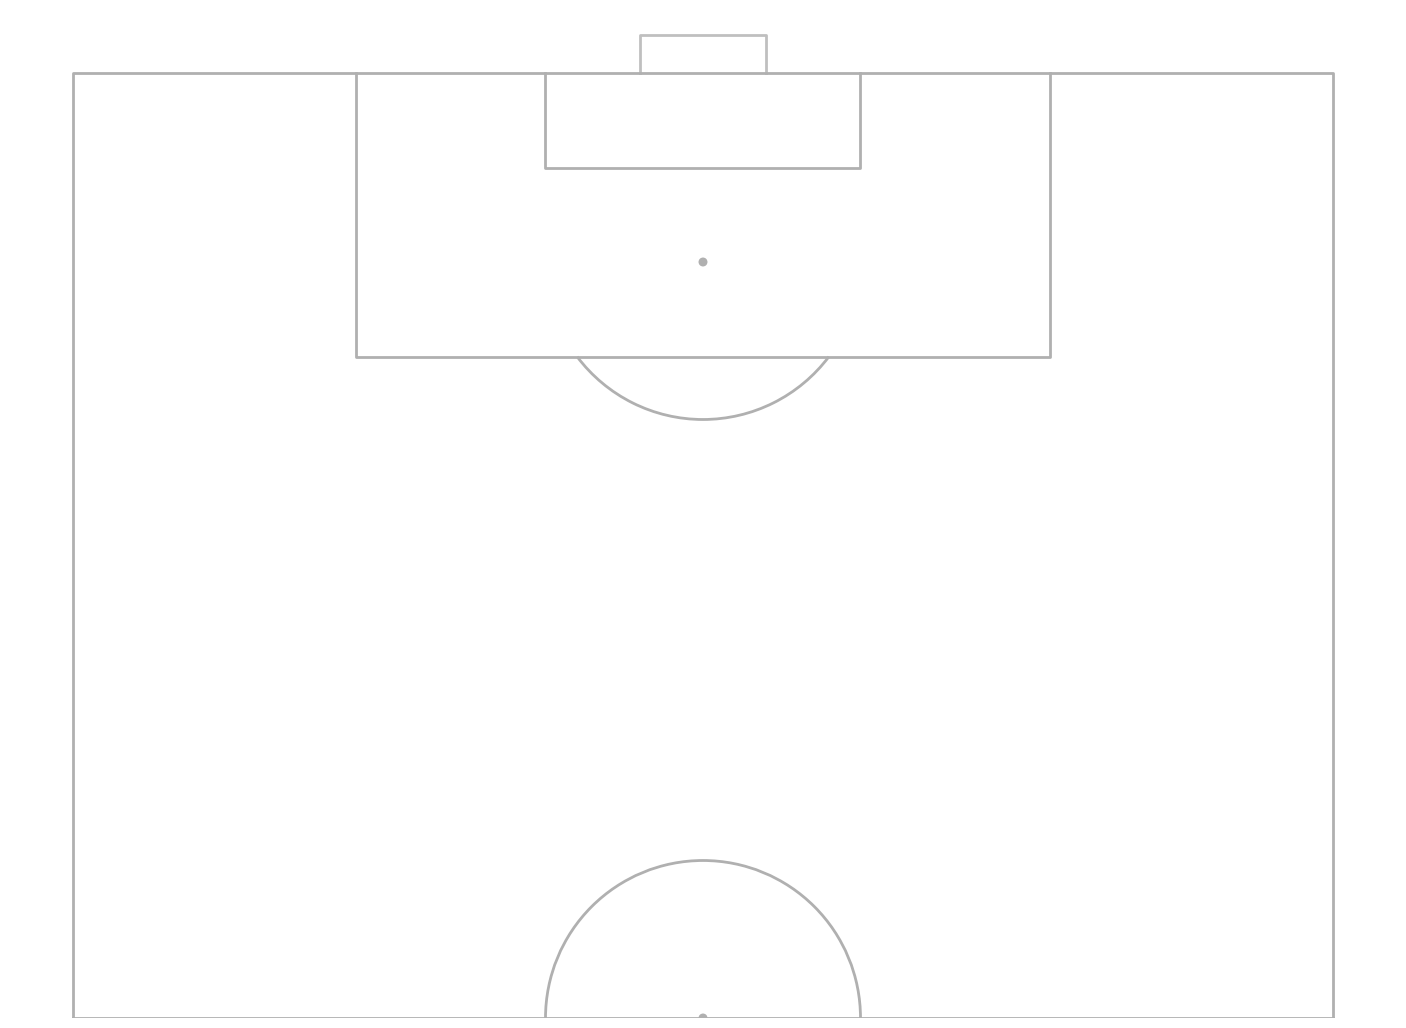

In [556]:
pitch = VerticalPitch(pad_bottom=0,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency
fig, ax = pitch.draw(figsize=(30, 10.38))
plt.savefig('pitch.png', format='png', bbox_inches='tight', pad_inches=0)


In [579]:
test = test_back.copy()
#we are going to create a contour plot to see how the heaviside function classifies onto a pitch
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from mplsoccer import Pitch, VerticalPitch, Sbopen
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
img = Image.open('pitch.png')

def xg_scatter(test):

    fig  = go.Figure()
    test['xG_display'] = test['xG'].map('xG: {:,.2f}'.format)
    test = test[test['posx']<50]
    test['posx'] = (test['posx'])*120/100
    test['posy'] = test['posy']*80/100

    
    fig.add_trace(
        go.Scatter(x = test['posy'],
                y = test['posx'],
                mode='markers',
                marker=dict(size=15,
                showscale=True, opacity=0.7),
                name='Salah',
                text = test['xG_display'],
                marker_color = test['xG'],
    ))

    # axis hide、yaxis reversed
    fig.update_layout(
        autosize=False,
        width=600*1.5,
        height=1000*1.2,
        xaxis=dict(visible=True,autorange=True, range = [-10, 80]),
        yaxis=dict(visible=True,autorange='reversed')
    )

    # background image add
    fig.add_layout_image(
        dict(source=img,
            xref='x',
            yref='y',
            x=-4,
            y=-3,
            sizex=88,
            sizey=53,
            sizing='stretch',
            opacity=1,
            layer='below')
    )

    # Set templates
    fig.update_layout(template="plotly_white")

    fig.show()

In [580]:
xg_scatter(test)

In [599]:
test = test_back.copy()
#we are going to create a contour plot to see how the heaviside function classifies onto a pitch
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from mplsoccer import Pitch, VerticalPitch, Sbopen
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import plotly.express as px
import plotly.graph_objects as go

from PIL import Image
img = Image.open('pitch.png')

def xg_(test):

    fig  = go.Figure()
    test['xG_display'] = test['xG'].map('xG: {:,.2f}'.format)
    test = test[test['posx']<50]
    test['posx'] = (test['posx'])*120/100
    test['posy'] = test['posy']*80/100

    bins1 = np.linspace(0, 50*120/100, 5)
    bins2 = np.linspace(0, 50*80/100, 5)

    test['cut1'] = pd.cut(test['posx'], bins1)
    test['cut2'] = pd.cut(test['posy'], bins2)

    pivot = test.pivot_table(index='cut1', columns='cut2', values='xG', aggfunc='mean')

    pivot.fillna(0, inplace=True)
    fig.add_trace(
        go.Heatmap(
          x = list(pivot.columns.values),
          y = list(pivot.index.values),
          z = pivot.values,
          type = 'heatmap',
          colorscale = 'Viridis'))
    

    # axis hide、yaxis reversed
    fig.update_layout(
        autosize=False,
        width=600*1.2,
        height=1100*1.2,
        xaxis=dict(visible=True,autorange=True, range = [-10, 80]),
        yaxis=dict(visible=True,autorange='reversed')
    )

    # background image add
    fig.add_layout_image(
        dict(source=img,
            xref='x',
            yref='y',
            x=-4,
            y=-4,
            sizex=88,
            sizey=60,
            sizing='stretch',
            opacity=1,
            layer='below')
    )

    # Set templates
    fig.update_layout(template="plotly_white")

    fig.show()

In [600]:
xg_(test)

[Interval(0.0, 15.0, closed='right'), Interval(15.0, 30.0, closed='right'), Interval(30.0, 45.0, closed='right'), Interval(45.0, 60.0, closed='right')]
[[1.1165796e-01 1.7592385e-01 3.3363041e-01]
 [8.5781768e-02 3.0473487e-02 9.4851844e-02]
 [1.2393409e-04 1.6241735e-02 4.5543034e-02]
 [          nan 3.3574921e-04           nan]]


TypeError: Object of type Interval is not JSON serializable

In [455]:
df['ended_in_goal'].value_counts()

0.0    2902
1.0     733
Name: ended_in_goal, dtype: int64

In [346]:
test = test_back.copy()
#we are going to create a contour plot to see how the heaviside function classifies onto a pitch
#first we must simulate the data above and we can do that by initializing 
#some numpy arrays what have certain properties
from mplsoccer import Pitch, VerticalPitch, Sbopen
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc


pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                    half=True,  # half of a pitch
                    goal_type='box',
                    goal_alpha=0.8)  # control the goal transparency
#fig, ax = pitch.draw(figsize=(8, 6))



test.dropna(inplace=True)

<AxesSubplot:xlabel='posy', ylabel='posx'>

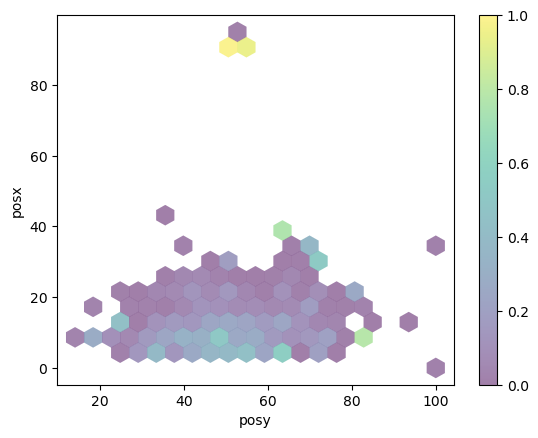

In [348]:
test.plot.hexbin('posy', 'posx', 'xG', gridsize=20, cmap='viridis', reduce_C_function=np.mean, alpha=0.5, vmin=0, vmax=1, edgecolors='face', linewidths=0.1)